# EBGN 594 Midterm 2024

In [1]:

# For reading data off the web
import pandas_datareader.data as web
import yfinance as yf

# Numerical 
import pandas as pd
import numpy as np

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from scipy.stats import jarque_bera, skewtest, kurtosistest
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Plotting 
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Datetime
from datetime import datetime

# Warnings filtering
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Define start and end dates
startdate = "2016-10-01"
enddate = "2024-09-29"

# Fetch data from FRED and Yahoo Finance
# Coinbase Bitcoin (CBBTCUSD), Break-even inflation (T5YIE), Henry Hub natural gas (DHHNGSP)
bitcoin = web.DataReader('CBBTCUSD', 'fred', startdate, enddate)
breakeven_inflation = web.DataReader('T5YIE', 'fred', startdate, enddate)
nat_gas = web.DataReader('DHHNGSP', 'fred', startdate, enddate)

# Fetch gold futures data from Yahoo Finance
gold_futures = yf.download('GC=F', start=startdate, end=enddate)

# Data Transformation
# Log transformation of bitcoin and natural gas prices, and extracting gold adjusted close prices
grd = pd.concat([
    np.log(bitcoin['CBBTCUSD']),
    breakeven_inflation['T5YIE'],
    np.log(nat_gas['DHHNGSP']),
    np.log(gold_futures['Adj Close'])
], axis=1)

# Removing missing values
grd.columns = ['crypt', 'bei', 'oil', 'gold']
grd = grd.dropna()

# Define variables for analysis
y = grd['crypt']
dy = y.diff().dropna()

x1 = grd['bei']
dx1 = x1.diff().dropna()

x2 = grd['oil']
dx2 = x2.diff().dropna()

x3 = grd['gold']
dx3 = x3.diff().dropna()

grd.head()

[*********************100%%**********************]  1 of 1 completed

,crypt,bei,oil,gold
2016-10-03,6.418349,1.47,1.043804,7.177019
2016-10-04,6.414016,1.45,1.040277,7.143855
2016-10-05,6.418626,1.48,1.040277,7.142985
2016-10-06,6.416536,1.49,1.111858,7.130739
2016-10-07,6.426456,1.50,1.105257,7.130018


1.	Provide two reasons why we might work with the natural log of the cryptocurrency, energy, and gold price variables but not the inflation expectations variable. 
- **Using log returns allows us to model the continuous compounding growth of asset prices that fluctuate continuously in financial markets. In contrast, the break-even inflation rate represents an expected percentage rate, which does not exhibit continuous compounding behavior and is more cyclical in nature, making the log transformation less relevant.**
- **Logging variables helps in analyzing their percentage changes over time, which is useful for normalizing price data that often have large variances and non-stationary behavior. However, the break-even inflation rate is already expressed in percentage terms, so logging the data may not add interpretability and could distort the data.**

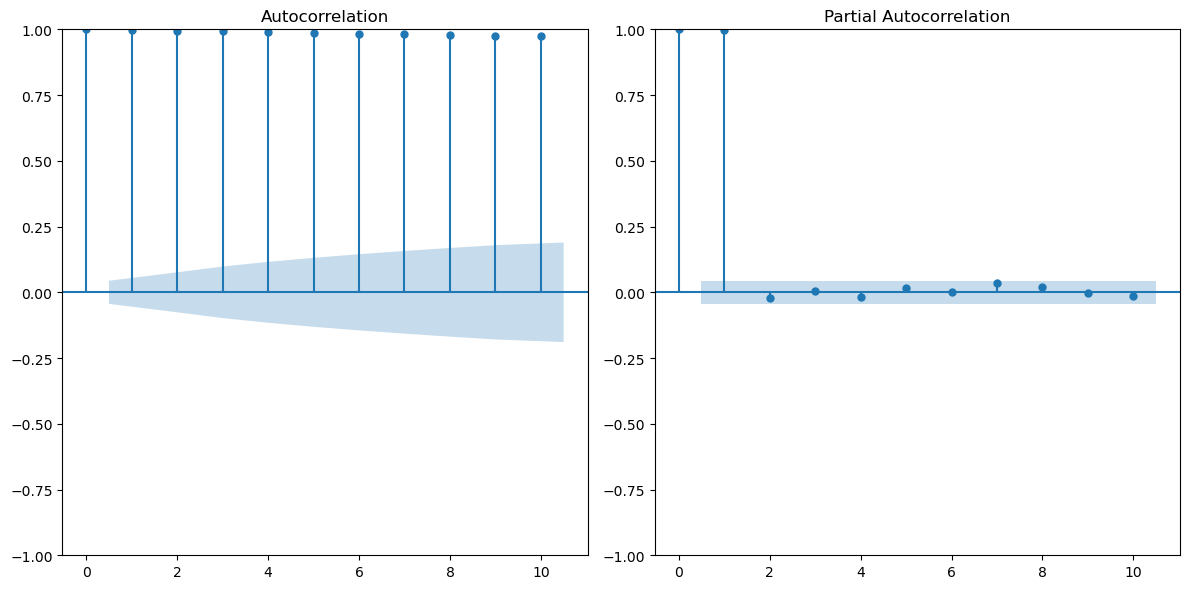

In [4]:
# Plotting ACF and PACF of log gold prices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(x3, lags=10, ax=ax[0])
plot_pacf(x3, lags=10, ax=ax[1])

plt.tight_layout()
plt.show()

 2.	The ACF pattern of decay is quick and exponential or slow and linear (still significant after many lags)? **Slow and linear**. 
 3.	The PACF coefficient on the first lag is very close to what number? **1** . The PACF becomes insignificant after how many lags? **2**
 4.	What do these observations suggest about stationarity? **This suggests nonstationarity and that the data may require some sort of differencing**


In [5]:
# ARMA(0,0) of first order differences
dx3_arma = ARIMA(dx3, order=(0,0,0)).fit()

print(dx3_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                   gold   No. Observations:                 1984
Model:                          ARIMA   Log Likelihood                6498.290
Date:                Mon, 14 Oct 2024   AIC                         -12992.580
Time:                        13:11:45   BIC                         -12981.394
Sample:                             0   HQIC                        -12988.471
                               - 1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.692      0.091   -5.52e-05       0.001
sigma2      8.367e-05   1.52e-06     55.211      0.000    8.07e-05    8.66e-05
Ljung-Box (L1) (Q):                   0.99   Jarque-

5.	Regress dx3 (first differences of x3) on an intercept only (e.g., ARMA(0,0) with intercept), and use this to find that the average growth (or decline) rate of the price is about **0.03%**. 

In [6]:
# Skewness
dx3_skew = skewtest(dx3)
# Kurtosis
dx3_kurt = kurtosistest(dx3)
# JB
dx3_jb = jarque_bera(dx3)
   
print(f'dx3 skewness: {dx3_skew} \n dx3 kurtosis: {dx3_kurt} \n dx3 JB: {dx3_jb}')

dx3 skewness: SkewtestResult(statistic=-4.623964720445301, pvalue=3.7647392488080247e-06) 
 dx3 kurtosis: KurtosistestResult(statistic=14.006266720815281, pvalue=1.427122339954551e-44) 
 dx3 JB: SignificanceResult(statistic=1488.1687049945617, pvalue=0.0)


 6.	The t-value for the skewness test is **-4.624** and the p-value is **3.764e-06**. Therefore I **reject** (reject/fail to reject) the null hypothesis of symmetrical distribution. 
 7.	The t-value for the excess kurtosis test is **14.006** and the p-value is **1.427e-44**. Therefore I **reject** (reject/fail to reject) the null hypothesis of **zero excess kurtosis**.
 8.	The value of the JB test statistic is **1488.17** and the p-value is **0.0**. Therefore I **reject** (reject/fail to reject) the null hypothesis of **normal distribution**.
 9.	The formula for the JB test statistic is **$JB=\frac{\hat{S}^2(r)}{6/T} + \frac{(\hat{K}(r)-3)^2}{24/T}$**. This is distributed Chi-square with 2 degrees of freedom because **the test assesses the sum of squares of two normal random variables, so k=2 for a $\Chi^k$ distribution in this case**.
 10. Describe why the Box test and the JB test statistics are both compared to a Chi-square distribution.
**Both of these tests are constructed by the sums of squared normal random variables, which is 2 for the case of the JB test, and some positive integer k for the Box test, and these random variables follow a Chi-squared distribution.**
 11. Briefly compare and contrast the null and alternative hypothesis of the Box test vs. the JB test. 
**The null hypothesis of the JB test is that the data is normally dsitributed, with the alternative being that the data is not normally distributed. The null hypothesis of the Box test is that the lags up to some positive integer m are all 0, with the alternative being that not all lags are 0 and there is at least 1 significant autocorrelation. In other words, the JB test uses the moments of a distribution to test if it is normally distributed, and the Box test uses the autocorrelation function to detect serial autocorrelation in time-series data.**
 12. If your test tells you that the data is not Normally distributed, what theorem tells you that estimated regression coefficients using the same type of data will still be Normally distributed across samples? Give a short intuitive explanation of how the theorem works. 
**The Central Limit Theorem ensures that these regression coefficients will converge to a normal distribution given a large enough sample size and small enough (finite) variance across all samples, even if the data being sampled is not normally distributed.**

In [7]:
# Case 4
y_adf4=adf(y,regression='ct',autolag='BIC',regresults=True)
print(y_adf4)

# Case 2 
y_adf2 = adf(y,regression='c')
print(y_adf2)

# Growth rate
grd.index = pd.to_datetime(grd.index)
monthly_avg = grd.groupby([grd.index.year, grd.index.month]).mean()
monthly_growth_rates = monthly_avg['crypt'].diff()
average_growth_rate = monthly_growth_rates.mean() * 100
print(f"Average Monthly Growth Rate: {average_growth_rate:.2f}%")



(-2.425345660824052, 0.3662333428348368, {'1%': -3.9633402937050963, '5%': -3.4127052046182866, '10%': -3.1283542258126102}, <statsmodels.stats.diagnostic.ResultsStore object at 0x000001F25FB86A90>)
(-2.3077100913002098, 0.16949337035871576, 3, 1981, {'1%': -3.4336552971929506, '5%': -2.8630000946528655, '10%': -2.5675472932714394}, -6569.131902350535)
Average Monthly Growth Rate: 4.79%


In [8]:

# Setting up for 15 and 16
y_lag1 = y.shift(1)

t = np.arange(len(y))  
t_series = pd.Series(t, index=y.index)

data_q15 = pd.DataFrame({
    'dy': dy,
    'y_lag1': y_lag1[dy.index],  # Align the lags with the diff
    't': t_series[dy.index]  # Align time index with the diff, converted to pandas Series
}).dropna()

# Regression model for 15-16
X = sm.add_constant(data_q15[['y_lag1', 't']])  
y = data_q15['dy']

model = sm.OLS(y, X).fit()
print(model.summary())

# Question 15
joint_hypothesis_15 = model.wald_test('const = 0, y_lag1 = 0, t = 0')
print(joint_hypothesis_15)
alpha = 0.05
df1 = 3 
df2 = model.df_resid  
critical_value_q15 = stats.f.ppf(1 - alpha, df1, df2)
print("Critical value for Test 15:", critical_value_q15)

# Question 16
joint_hypothesis_16 = model.wald_test('y_lag1 = 0, t = 0')
print(joint_hypothesis_16)
df1 = 2  
critical_value_q16 = stats.f.ppf(1 - alpha, df1, df2)
print("Critical value for Test 16:", critical_value_q16)

# Question 18
X_q18 = sm.add_constant(data_q15[['y_lag1']])  
model_q18 = sm.OLS(data_q15['dy'], X_q18).fit()
print(model_q18.summary())
test_q18_joint = model_q18.wald_test('const = 0, y_lag1 = 0')
print(test_q18_joint)


                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.760
Date:                Mon, 14 Oct 2024   Prob (F-statistic):             0.0235
Time:                        13:11:45   Log-Likelihood:                 3340.5
No. Observations:                1984   AIC:                            -6675.
Df Residuals:                    1981   BIC:                            -6658.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0368      0.013      2.740      0.0

13.	Implement the test for “Case 4” (intercept and trend). Using the BIC, the optimal number of lags of first differences for the ADF test is **0**. 
14.	The individual test statistic for a unit root is **-2.4253** and the critical value is **-3.4127**. Therefore I **fail to reject** (reject/fail to reject) the null hypothesis of **the data having a unit root**.
15.	The joint test statistic for the unit root, the trend, and the intercept is **4.3284** and the critical value is **2.609**. 
16.	The joint test statistic for the unit root and the trend is **5.7128** and the critical value is **3.000**.
17.	Write the equation of the ADF test you implemented and state the null and alternative hypotheses in terms of the coefficients here:

\begin{align*}
\Delta Y_t = \alpha + \beta_t + \gamma Y_{t-1} + \epsilon_t \\  
H_0: \quad \gamma = 0 \text{, or the data has a unit root} \\  
H_a: \quad \gamma < 0 \text{, or the data does not have a unit root}
\end{align*}

18.	Implement the test for “Case 2” (intercept and but no trend). The test statistic for the unit root is **-2.3077** and the critical value is **-2.8630**. The joint test statistic for the unit root and the intercept is **5.4146** and the critical value is **3.0003**. 
19.	Consider the results in this series of questions. You can conclude that there **is**  a unit root with **trend** (drift/trend/both/neither).
20.	Based on all of this evidence, the average growth (or decline) rate of the series is about **4.79** percent per month. 

In [9]:
# LB-test for 30 lags
ljb_dy = acorr_ljungbox(dy, lags=30)
stat = ljb_dy['lb_stat'].values[-1]
p = ljb_dy['lb_pvalue'].values[-1]
print(f'Statistic: {stat}, p-val: {p}')

Statistic: 35.406612982736526, p-val: 0.22814644637913295


21.	First let’s find out if dy is autocorrelated. Conduct a Ljung-Box test on dy, jointly testing 30 autocorrelations. The value of the test statistic is **35.407** and the p-value of the test is **0.228**. Regarding autocorrelation, we conclude **we fail to reject the null hypothesis that the data is independently distributed, or alternatively, the data is not serially correlated for 30 lags.**.
22.	Provide the recipe, i.e., list the sequence of operations for finding the optimal ARMA model for a series like dy in order to “whiten” the residuals. 

**1. Initial model selection - check for stationarity using metrics such as the ADF test, and use the ACF/PACF plots to determine optimal p/q parameters for an ARMA model.** 

**2. Fit multiple ARMA models - in this case, fit models from ARMA(0,0) to ARMA(12,12)**

**3. Evaluate models - use AIC or BIC to determine goodness-of-fit and choose models with minimized ICs. Perform diagnostics (such as the LB test) on residuals to ensure there is no autocorrelation in the errors.**

**4. Optimization - Choose model with best parameters and iteratively tune it.**


                               SARIMAX Results                                
Dep. Variable:                  crypt   No. Observations:                 1984
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3334.045
Date:                Mon, 14 Oct 2024   AIC                          -6662.090
Time:                        13:11:45   BIC                          -6645.311
Sample:                             0   HQIC                         -6655.926
                               - 1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3164     11.891      0.027      0.979     -22.990      23.623
ma.L1         -0.3177     11.885     -0.027      0.979     -23.611      22.976
sigma2         0.0020   2.93e-05     69.231      0.0

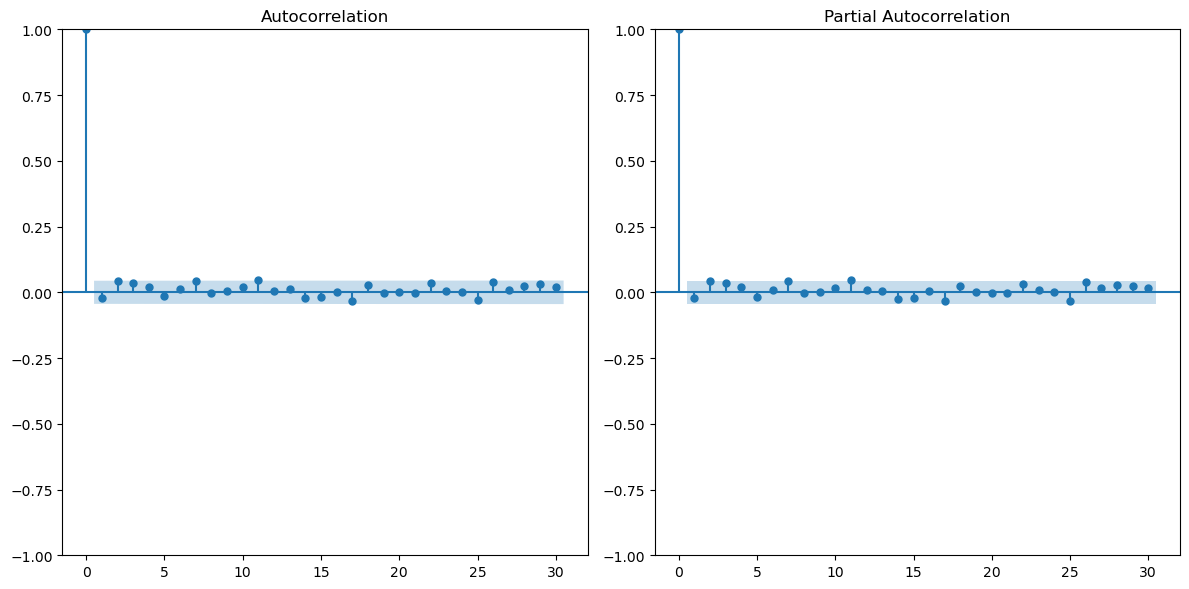

Forecasted val 6 days out:  -2.8101015440196434e-08


In [10]:
# ARMA(1,1) model with no intercept
arma_p23 = ARIMA(dy,order=(1,0,1),trend='n').fit()
print(arma_p23.summary())

# Residual ACF
resids = arma_p23.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(resids,lags=30,ax=ax[0])
plot_pacf(resids,lags=30,ax=ax[1])
plt.tight_layout()
plt.show()

# Forecast
forecast=arma_p23.forecast(steps=6)
print('Forecasted val 6 days out: ', forecast.iloc[-1])

23.	Please estimate an ARMA(1,1) with no intercept for dy (regardless of whether this is “optimal”) and write the equation for your model in AR and MA lag polynomial form here, using the numerical estimates of the coefficients:

\begin{align*}
(1-.3164L)dy_t=(1+.3177L)\epsilon_t
\end{align*}

24.	Looking at the ACF of the residuals of your ARMA(1,1), are there any seriously concerning autocorrelations (other than a few tiny ones)?

**No. There are no significant spikes outside of the 95% confidence intervals, so there is no real concern with autocorrelation in the residuals.**

25.	Using the ARMA(1,1), the forecasted return six days from the last observation is **-2.8101015440196434e-08**. 


In [11]:
# Combine the differenced data into a single DataFrame and drop any rows with NaNs
data = pd.concat([dy, dx1, dx2, dx3], axis=1).dropna()

Y = data['crypt']
X = data[['bei', 'oil', 'gold']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

# 29
t_dx2 = (.0038-1)/.012
print('t-stat for dx2: ',t_dx2)

# 32 
X_restricted = sm.add_constant(data['bei'])
restricted = sm.OLS(Y,X_restricted).fit()

f_test = model.compare_f_test(restricted)

print(f'F-value: {f_test[0]}, p-value: {f_test[1]}, Degrees of freedom difference: {f_test[2]}')

# 35
ols_hac = model.get_robustcov_results(cov_type='HAC',maxlags=12)
print(ols_hac.summary())

t_dx2_hac = (.0038-1)/.015

print('t_stat of dx_2 with HAC: ', t_dx2_hac)


                            OLS Regression Results                            
Dep. Variable:                  crypt   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9.161
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           5.09e-06
Time:                        13:11:45   Log-Likelihood:                 3350.4
No. Observations:                1984   AIC:                            -6693.
Df Residuals:                    1980   BIC:                            -6670.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.163      0.0

26.	The estimated regression equation is (please write or type out the equation):

\begin{align*}
dy = .0022 + .0675 dx_1 + .0038 dx_2 + .4627 dx_3 + e_t
\end{align*}

27.	Please provide a written interpretation of the numerical value of the estimated dx2 coefficient. How much of the percentage change in oil prices get passed through to the percentage change in the cryptocurrency price?
**Holding all else equal, a 1% increase in oil prices induces a .0038% change in Bitcoin price on average.**

28.	Using regular standard errors, the t-statistic for the Null Hypothesis that the dx2 coefficient is equal to ZERO is .315. Therefore I **fail to reject**  the Null.

29.	Suppose you thought changes in energy (oil) prices should get passed through one-for-one to changes in crypto. Using regular standard errors, the t-statistic for the Null Hypothesis that the dx2 coefficient is equal to ONE is **83.017**. Therefore I **reject** the Null. 

30.	The key assumption for the dx2 coefficient estimate to be unbiased is:
**exogeneity, meaning that it is uncorrelated with the error term**

31.	Name one reason this assumption may fail in this example:

**During recessionary periods, consumer income will decrease, leading to decreased demand in both Bitcoin and Oil. These prices could be influenced by the same or similar economic factors, like decreased consumer expenditure, which means they may be correlated about some unobserved process, which would violate the assumption of exogeneity.**

32.	Using the regular “plain vanilla” covariance matrix, conduct an F-test for the joint significance of dx2 and dx3 in explaining dy. The calculated F-statistic is **8.861730044856083** and the p-value is **0.0001474084281147922**. Therefore I **reject** the Null. 

33.	Formally state the null and alternative hypotheses of the F-test from the previous question. 

\begin{align*}
H_0: \beta_2=\beta_3=0 \text{ (i.e. dx2 and dx3 have no effect on the change of Bitcoin prices)} \\ 
H_a: \beta_2 \neq 0 \text{ and/or } \beta_3 \neq 0 \text{ (i.e. either dx2 or dx3 (or both) have significant effect on Bitcoin prices)}
\end{align*}

34.	The key assumptions for the dx2 coefficient estimate to be efficient (minimum variance) are:

**In order for dx2 to be BLUE it must have linear parameters, the data must be obtained from a random sample, there is no perfect multicollinearity with other independent variables, dx2 is exogenous, the errors must be homoskedastic, and there is no autocorrelation in the errors.**




35.	The HAC standard error for the dx2 coefficient is **.0038**, and the t-statistic for the Null Hypothesis that this coefficient is equal to ONE using this standard error is **.015**. Therefore I now **reject** the Null using HAC standard errors. 


36.	If the assumptions you listed for efficiency fail, which part or parts (if any or all) of the assumptions are addressed by HAC standard errors?

**HAC errors help correct for heteroskedastic standard errors and autocorrelated standard errors**



In [12]:
# LB test on model resids
model_residuals = model.resid
model_ljb = acorr_ljungbox(model_residuals, lags=10)
print('Statistic: ',model_ljb['lb_stat'].values[-1], 'p-val: ', model_ljb['lb_pvalue'].values[-1])

# Model w ARMA
arma_resids = ARIMA(model_residuals,order=(1,0,1)).fit()
print(arma_resids.summary())

arma_model = ARIMA(Y, exog=X, order=(1, 0, 1), trend='n').fit()

new_coeff_dx2 = arma_model.params['oil']
new_se_dx2 = arma_model.bse['oil']
print(f"New coefficient for dx2: {new_coeff_dx2}")
print(f"New standard error for dx2: {new_se_dx2}")

Statistic:  13.573222841300527 p-val:  0.1933630233766915


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1984
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3351.495
Date:                Mon, 14 Oct 2024   AIC                          -6694.991
Time:                        13:11:46   BIC                          -6672.619
Sample:                             0   HQIC                         -6686.773
                               - 1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.592e-06      0.001     -0.003      0.998      -0.002       0.002
ar.L1         -0.0647      0.601     -0.108      0.914      -1.243       1.114
ma.L1          0.0332      0.602      0.055      0.9

New coefficient for dx2: 0.003817809412586077
New standard error for dx2: 0.010256514078710364


**Note that I'm using the original model with plain standard errors for these next questions since it isn't specified** 

37.	Conduct a Portmanteau/Box test on the residuals of the model, jointly testing 10 autocorrelations. The value of the test statistic is **13.57322** and the p-value of the test is **.19336**. Therefore I **fail to reject** (reject/fail to reject) the Null of zero autocorrelation.

38.	Reestimate the model of dy as a linear function of dx1, dx2, and dx3 but this time please include an ARMA(1,1) model for the residuals. The new coefficient and standard error on dx2 are **New coefficient for dx2: 0.003817809412586077
New standard error for dx2: 0.010256514078710364**. Therefore I now **fail to reject**  the Null Hypothesis that the dx2 coefficient is equal to ZERO. 

39.	What can you conclude about the causal vs. predictive/correlational relationship between cryptocurrency and energy price fluctuations, inflation expectations, and gold? 

**Oil in this analysis seems to have little correlation or statistical significance in predicting Bitcoin prices. For inflation, we have limited evidence that there is any strong correlational/causal relationship with Bitcoin prices, so we cannot say it is statistically significant to Bitcoin prices. Gold prices, however, have a more statistically significant relationship with Bitcoin. The prices are positively correlated, but in order for us to infer any sort of causal relationship between the two variables, more analysis is required to confirm that these prices are indeed exogenous and are not jointly determined by an outside process.**

40.	Now please use a Bai & Perron test for structural breaks in your regression equation of dy on dx1, dx2, and dx3 (i.e. you can use the strucchange package in R). The optimal number of breaks that minimizes the BIC is **0**. These breaks occur at dates **N/A**. 

**An R file will be included for 40 since there is no Bai-Perron test built into Python**
